# Notebookの下準備

In [1]:
# black formatterの設定
import jupyter_black

jupyter_black.load()

In [2]:
DATASET_TYPE = "SMALL"  # RECODE or SMALL

In [3]:
import itertools
import pickle
import shelve
import numpy as np
import pandas as pd
import scipy.linalg as spl
import scipy.stats
import scipy.stats as sps
import sklearn
import sklearn.mixture
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap
import time

import glob
import csv
import screcode
from scipy.stats import multivariate_normal
import seaborn as sns

sns.set_style("whitegrid")
from natsort import natsorted
import ot

# import ot.plot
import matplotlib.animation as animation
from PIL import Image
from matplotlib.animation import PillowWriter
import itertools
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils import check_random_state
from IPython.display import HTML, display
from IPython.display import Image
import warnings

warnings.filterwarnings("ignore")
from scipy import interpolate
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
import pydotplus
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

import os
from tqdm import tqdm

In [4]:
# pathの最後がディレクトリの場合はスラッシュをつける

# --- 加工前のデータセットのpath ---
DATASET_INPUT_ROOT_PATH = os.path.join(os.getcwd(), "dataset/input/")
DATASET_PATH_BEFORE_PCA = os.path.join(
    DATASET_INPUT_ROOT_PATH,
    "usedataSMALL/" if DATASET_TYPE == "SMALL" else "usedataRECODE/",
)

# TODO: ディレクトリの作成タイミング考える
# --- 保存先path ---
# 加工後データセット
DATASET_OUTPUT_ROOT_PATH = os.path.join(os.getcwd(), "dataset/output/")
DATASET_PATH_WITHOUT_MT = os.path.join(
    DATASET_OUTPUT_ROOT_PATH,
    "usedataSMALL_withoutMT/"
    if DATASET_TYPE == "SMALL"
    else "usedataRECODE_withoutMT/",
)
DATASET_PATH_AFTER_PCA = os.path.join(DATASET_PATH_WITHOUT_MT, "logPCA/")
DATASET_PATH_AFTER_UMAP = os.path.join(DATASET_PATH_WITHOUT_MT, "logUMAP/")
# データセット以外のoutputのpath
OUTPUT_PATH_OTHER_THAN_DATASET = os.path.join(os.getcwd(), "output/")
GMM_PATH = os.path.join(OUTPUT_PATH_OTHER_THAN_DATASET, "gmm/")
GMM_MODEL_PATH = os.path.join(GMM_PATH, "models/")
GMM_LABEL_PATH = os.path.join(GMM_PATH, "labels/")
PCA_MODEL_PATH = os.path.join(OUTPUT_PATH_OTHER_THAN_DATASET, "pca/")
UMAP_MODEL_PATH = os.path.join(OUTPUT_PATH_OTHER_THAN_DATASET, "umap/")
FIGURE_PATH_PCA = os.path.join(OUTPUT_PATH_OTHER_THAN_DATASET, "figure_PCA/")
FIGURE_PATH_UMAP = os.path.join(OUTPUT_PATH_OTHER_THAN_DATASET, "figure_UMAP/")
VIDEO_PATH = os.path.join(OUTPUT_PATH_OTHER_THAN_DATASET, "video/")

DATASET_NAMES_BY_DAY = ["D0", "D05", "D1", "D15", "D2"]
DAY_LIST_WITH_DECIMAL_POINT = ["0", "0.5", "1", "1.5", "2"]
FIGURE_TITLES_BY_DAY = [f"Day {day}" for day in DAY_LIST_WITH_DECIMAL_POINT]
FIGURE_NAMES_BY_DAY = [f"Day{day}" for day in DAY_LIST_WITH_DECIMAL_POINT]

# 共通
RANDOM_STATE = 2022
# PCA
PCA_N_COMPONENTS = 30  # 150
# GMM
GMM_CLUSTER_NUMBERS = [1, 2, 4, 5, 5]  # 各dayのクラスタ数
# UMAP
UMAP_N_NEIGHBORS = 1000
UMAP_N_COMPONENTS = 2

# クラス

In [100]:
class scEGOT:
    """
    scEGOT class

    Parameters
    ----------
    pca_n_components : int
        The estimated number of components in PCA.
    gmm_n_components_list : array of shape (n_days, )
        List of the number of misture components (n_components) of GMM
        for each day.

    umap_n_components : int
        The estimated number of components in UMAP.
    umap_n_neighbors : float
        The size of local neighborhood (in terms of number of neighboring
        sample points) used for manifold approximation.
        See: https://umap-learn.readthedocs.io/en/latest/parameters.html#n-neighbors
    verbose : boolean, default=True
        If True, print status data during processing.

    Attributes
    ----------
    n_days : int
        Number of days in the training data.
    """

    # ---------- 初期化 ----------
    def __init__(
        cls,
        pca_n_components,
        gmm_n_components_list,
        *,
        umap_n_components=None,
        umap_n_neighbors=None,
        verbose=True,
    ):
        cls.pca_n_components = pca_n_components
        cls.gmm_n_components_list = gmm_n_components_list

        cls.umap_n_components = umap_n_components
        cls.umap_n_neighbors = umap_n_neighbors
        cls.verbose = verbose

    # ---------- 前処理 ----------
    def _preprocess_recode(self, X):
        """Apply scRECODE to X. Return transformed X.
        See: https://yusuke-imoto-lab.github.io/RECODE/

        Parameters
        ----------
        X : array-like of shape (n_days, n_samples, n_features)
            The data to apply scRECODE.

        Returns
        ----------
        X : array-like of shape (n_days, n_samples, n_genes)
            The data with scRECODE applied.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        n_samples : int
            Number of samples in the tranining data.
        n_genes : int
            Number of genes(features) in the training data.
        """
        for i in range(len(X)):
            X[i] = pd.DataFrame(
                screcode.RECODE(verbose=self.verbose).fit_transform(X[i].values),
                index=X[i].index,
                columns=X[i].columns,
            )
        return X

    def _preprocess_pca(self, X_concated):
        """Apply PCA to X_concated. Return transformed X_concated and fitted
        PCA instance.

        X_concated is assumed to be the two-dimensional data
        concatenated two-dimensional data for each day.

        Parameters
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            The data to apply UMAP.

        Returns
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            The data with PCA applied.
        pca_model : PCA instance
            PCA instance fitted with X_concated.

        Attributes
        ----------
        n_samples : int
            Number of samples in the tranining data.
        n_genes : int
            Number of genes(features) in the training data.
        """
        pca_model = PCA(n_components=self.pca_n_components)
        X_concated = pd.DataFrame(
            pca_model.fit_transform(X_concated.values),
            index=X_concated.index,
            columns=["PC{}".format(i + 1) for i in range(self.pca_n_components)],
        )
        return X_concated, pca_model

    # calculate.py
    def _normalize_umi(self, X_concated, UMI_norm=100000):
        """Normalize UMI counts. Return UMI-normalized X_concated.

        Parameters
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            The data to normalize UMI counts.
        UMI_norm : int, default=100000
            ???

        Returns
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            The data with normalized UMI counts.

        Attributes
        ----------
        n_samples : int
            Number of samples in the tranining data.
        n_genes : int
            Number of genes(features) in the training data.
        """
        X_concated = X_concated.div(X_concated.sum(axis=1), axis=0) * UMI_norm
        return X_concated

    # calculate.py
    def _normalize_log1p(self, X_concated):
        """Calculate natural logarithm of one plus the X_concated.
        Return log1p-normalized X_concated.

        Replace values less than or equal to 0 with 0.

        Parameters
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            The data to calculate natural logarithm.

        Returns
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            Natural logarithm of X_concated + 1.

        Attributes
        ----------
        n_samples : int
            Number of samples in the tranining data.
        n_genes : int
            Number of genes(features) in the training data.
        """
        X_concated = X_concated.where(X_concated > 0, 0)
        X_concated = pd.DataFrame(
            np.log1p(X_concated.values),
            index=X_concated.index,
            columns=X_concated.columns,
        )
        return X_concated

    def normalize_data(self, X_concated):
        """Normalize X_concated. Return normalized X_concated.

        Perform only normalization, not dimensionality reduction.
        UMInormalize -> Log2scaling

        Parameters
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            The data to normalize.

        Returns
        ----------
        X_concated : array-like of shape (n_samples, n_genes)
            Normalized X.

        Attributes
        ----------
        n_samples : int
            Number of samples in the tranining data.
        n_genes : int
            Number of genes(features) in the training data.
        """
        X_concated = self._normalize_umi(X_concated)
        X_concated = self._normalize_log1p(X_concated)
        return X_concated

    # utils.py
    def _split_dataframe_by_row(self, df, row_counts):
        """Split df by rows specified in row_counts.

        Parameters
        ----------
        df : DataFrame
            DataFrame to be split.
        row_counts : array of shape (n_divisions, )
            Array of the number of rows in each DataFrame after spliting.

        Returns
        ----------
        df_list : array-like of shape (n_divisions, )
            Array of DataFrame objects.
            The number of rows in each DataFrame matches row_counts.

        Attributes
        ----------
        n_divisions : int
            Number of DataFrame to split.
        """
        split_indices = list(itertools.accumulate(row_counts))
        df_list = [
            df.iloc[split_indices[i - 1] if i > 0 else 0 : split_indices[i]]
            for i in range(len(split_indices))
        ]
        return df_list

    def preprocess(
        self,
        X,
    ):
        """Preprocess X. Return transformed X and fitted PCA instance.

        Preprocess in the following order.
        UMInormalize -> Log2scaling -> PCA

        X is assumed to be an array whose elements are two-dimensional data
        for each day.

        Parameters
        ----------
        X : array-like of shape (n_days, n_samples, n_genes)
            Training data to preprocess.

        Returns
        ----------
        X : array-like of shape (n_days, n_sample, pca_n_components)
            Preprodessed and dimensionality reduced X.
        pca_model : PCA instance
            PCA instance fitted with training data.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        n_samples : int
            Number of samples in the tranining data.
        n_genes : int
            Number of genes(features) in the training data.
        pca_n_components : int
            Number of components to keep in PCA.
        """

        X = self._preprocess_recode(X)
        X_concated = pd.concat(X)
        X_concated = self.normalize_data(X_concated)
        X_concated, pca_model = self._preprocess_pca(X_concated)
        if self.verbose:
            print(
                f"sum of explained_variance_ratio = {sum(pca_model.explained_variance_ratio_ * 100)}"
            )
        X = self._split_dataframe_by_row(X_concated, [len(x) for x in X])

        return X, pca_model

    # ---------- UMAP ----------
    def _apply_umap_to_concated_data(
        self,
        X_concated,
        random_state=None,
        min_dist=0.8,
    ):
        """Apply UMAP to X_concated. Return transformed X_concated and fitted
        UMAP instance.

        See: https://umap-learn.readthedocs.io/en/latest/index.html

        X_concated is assumed to be the two-dimensional data
        concatenated two-dimensional data for each day.

        Parameters
        ----------
        X_concated : array-like of shape (n_samples, pca_n_components)
            The data to apply UMAP.
        random_state : int, RandomState instance or None, default=None
            Determing seed that initializes random number generator.
        min_dist : float, default=0.8
            The effective minimum distance between embedded points.
            See: https://umap-learn.readthedocs.io/en/latest/parameters.html#min-dist

        Returns
        ----------
        X_concated : array-like of shape (n_samples, umap_n_components)
            X_concated with UMAP applied.
        umap_model : UMAP instance
            UMAP instance fitted with training data.

        Attributes
        ----------
        n_samples : int
            Number of samples in the tranining data.
        pca_n_components : int
            Number of features in X_concated. Matches PCA's n_components.
        umap_n_components : int
            Number of components to keep in UMAP.
        """
        umap_model = umap.UMAP(
            n_components=self.umap_n_components,
            n_neighbors=self.umap_n_neighbors,
            random_state=random_state,
            min_dist=min_dist,
        )
        X_concated = pd.DataFrame(
            umap_model.fit_transform(X_concated.values),
            index=X_concated.index,
            columns=["UMAP1", "UMAP2"],
        )
        return X_concated, umap_model

    def apply_umap(self, X, random_state=None, min_dist=0.8):
        """Apply UMAP to X. Return transformed X and fitted UMAP instance.

        See: https://umap-learn.readthedocs.io/en/latest/index.html

        Parameters
        ----------
        X : array-like of shape (n_days, n_samples, pca_n_components)
            The data to apply UMAP.
        random_state : int, RandomState instance or None, default=None
            Determing seed that initializes random number generator.
        min_dist : float, default=0.8
            The effective minimum distance between embedded points.
            See: https://umap-learn.readthedocs.io/en/latest/parameters.html#min-dist

        Returns
        ----------
        X_concated : array-like of shape (n_samples, umap_n_components)
            X_concated with UMAP applied.
        umap_model : UMAP instance
            UMAP instance fitted with training data.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        n_samples : int
            Number of samples in the tranining data.
        pca_n_components : int
            Number of features in X. Matches PCA's n_components.
        umap_n_components : int
            Number of components to keep in UMAP.
        """
        X_concated = pd.concat(X)
        X_concated, umap_model = self._apply_umap_to_concated_data(
            X_concated, random_state, min_dist
        )
        X = self._split_dataframe_by_row(X_concated, [len(x) for x in X])
        return X, umap_model

    # ---------- GMM ----------
    def fit_gmm(self, X, random_state=None):
        """Apply GMM to X.

        GMM stands for Gaussian Mixture model.
        See: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

        X is assumed to be an array whose elements are two-dimensional data
        for each day.

        Parameters
        ---------
        X : array-like of shape (n_days, n_samples, pca_n_components)
            The data to apply GMM.
        random_state : int, RandomState instance or None, default=None
            Determing seed that initializes random number generator.

        Returns
        ----------
        gmm_models : array-like of shape (n_days, )
            List of scikit-learn's Gaussian Mixture model for eacy day.

        Attributes
        ---------
        n_days :
            Number of days in the training data.
        n_samples :
            Number of samples in the training data.
        pca_n_components : int
            Number of features in X. Matches PCA's n_components.
        """
        gmm_models = []

        for i in tqdm(range(len(X))) if self.verbose else range(len(X)):
            gmm_model = sklearn.mixture.GaussianMixture(
                self.gmm_n_components_list[i],
                covariance_type="full",
                max_iter=2000,
                n_init=10,
                random_state=random_state,
            )
            gmm_model.fit(X[i].values)
            gmm_models.append(gmm_model)

        return gmm_models

    def fit_predict_gmm(self, X, random_state=None):
        gmm_models, gmm_labels = [], []

        for i in tqdm(range(len(X))) if self.verbose else range(len(X)):
            gmm_model = sklearn.mixture.GaussianMixture(
                self.gmm_n_components_list[i],
                covariance_type="full",
                max_iter=2000,
                n_init=10,
                random_state=random_state,
            )
            gmm_labels.append(gmm_model.fit_predict(X[i].values))
            gmm_models.append(gmm_model)

        return gmm_labels, gmm_models

    def predict_gmm_label(self, X_item, gmm_model):
        return gmm_model.predict(X_item.values)

    def predict_gmm_labels(self, X, gmm_models):
        gmm_labels = [
            self.predict_gmm_label(X[i], gmm_models[i]) for i in range(len(X))
        ]
        return gmm_labels

    def _plot_gmm_predictions(
        self,
        X_item,
        x_range,
        y_range,
        figure_labels=None,
        gmm_labels=None,
        gmm_n_components=None,
    ):
        """Plot X_item in two dimensions.

        If gmm_labels are given, each sample is color-coded by label.

        Parameters
        ----------
        X_item : array-like of shape (n_samples, n_features)
            The data to plot.
        x_range : tuple of shape (2, ), default=None
            A tuple of x-axis limits.
        y_range : tuple of shape (2, ), default=None
            A tuple of y-axis limits.
        figure_labels : ndarray of shape (2, ), default=None
            Labels for x- and y-axis.

        Attributes
        ---------
        n_samples :
            Number of samples in X_item.
        n_features :
            Number of features in X_item. Matches PCA's n_components or UMAP's n_components.
        """
        if gmm_labels is None:
            plt.scatter(X_item.values[:, 0], X_item.values[:, 1], s=0.5, alpha=0.8)
        else:
            plt.scatter(
                X_item.values[:, 0],
                X_item.values[:, 1],
                c=gmm_labels,
                cmap=plt.cm.get_cmap("cubehelix", gmm_n_components),
                edgecolor="gray",
            )
            plt.colorbar(ticks=range(gmm_n_components), label="cluster")
            plt.clim(-0.5, gmm_n_components - 0.5)

        if figure_labels is not None:
            plt.xlabel(figure_labels[0])
            plt.ylabel(figure_labels[1])

        plt.xlim(x_range)
        plt.ylim(y_range)

    def plot_gmm_predictions(
        self,
        X,
        gmm_models,
        gmm_labels,
        x_range=None,
        y_range=None,
        figure_labels=None,
        figure_titles_without_gmm=None,
        figure_titles_with_gmm=None,
        plot_gmm_means=False,
        save=False,
        save_paths=None,
    ):
        """Show side-by-side display of X without and with GMM labels.

        Parameters
        ----------
        X : array-like of shape (n_days, n_samples, n_features)
            The data to predict GMM labels in each samples.
        gmm_models : ndarray of shape (n_days, )
            List of GMM models for each day.
        gmm_labels : ndarray of shape (n_days, )
        x_range : tuple of shape (2, ), default=None
            A tuple of x-axis limits.
        y_range : tuple of shape (2, ), default=None
            A tuple of y-axis limits.
        figure_labels : ndarray of shape (2, ), default=None
            Labels for x- and y-axis.
        figure_titles_without_gmm : ndarray of shape (n_days, ), default=None
            List of titles of figures without GMM labels.
        figure_titles_with_gmm : ndarray of shape (n_days, ), default=None
            List of titles of figures with GMM labels.
        plot_gmm_means : bool, default=False
            if true, plot means of each GMM distribution.
        save : bool, default=False
            If true, save each day's figure in a image file.
        save_paths : ndarray of shape (n_days, ), default=None
            Only works if save=True.
            Specify where to save each image.

        Attributes
        ----------
        n_days:
            Number of days in the training data.
        n_samples:
            Number of samples in the training data.
        n_features:
            Number of features in X. Matches PCA's n_components or UMAP's n_components.
        """
        if x_range is None:
            x_min = min([np.min(df.iloc[:, 0].values) for df in X])
            x_max = max([np.max(df.iloc[:, 0].values) for df in X])
            x_range = (x_min - (x_max - x_min) / 10, x_max + (x_max - x_min) / 10)

        if y_range is None:
            y_min = min([np.min(df.iloc[:, 1].values) for df in X])
            y_max = max([np.max(df.iloc[:, 1].values) for df in X])
            y_range = (y_min - (y_max - y_min) / 10, y_max + (y_max - y_min) / 10)

        if figure_titles_without_gmm is None:
            figure_titles_without_gmm = [
                f"Figure {i} - wighout GMM" for i in range(len(X))
            ]

        if figure_titles_with_gmm is None:
            figure_titles_with_gmm = [f"Figure {i} - with GMM" for i in range(len(X))]

        if save is not None and save_paths is None:
            save_file_paths = [f"./GMM_preds_figure_{i}.png" for i in range(len(X))]

        for i in range(len(X)):
            plt.figure(figsize=(20, 8))

            plt.subplot(1, 2, 1)
            self._plot_gmm_predictions(X[i], x_range, y_range, figure_labels)
            plt.title(figure_titles_without_gmm[i], fontsize=20)

            plt.subplot(1, 2, 2)
            gmm_model = gmm_models[i]

            if plot_gmm_means:
                for k in range(self.gmm_n_components_list[i]):
                    plt.plot(gmm_model.means_[k][0], gmm_model.means_[k][1], "ro")

            self._plot_gmm_predictions(
                X[i],
                x_range,
                y_range,
                figure_labels,
                gmm_labels[i],
                self.gmm_n_components_list[i],
            )
            plt.title(figure_titles_with_gmm[i], fontsize=20)

            if save:
                plt.savefig(save_paths[i], dpi=600)
            plt.show()

    # ---------- movie ----------
    def interpolation_contour(self, gmm_source, gmm_target, t, x_range, y_range):
        """Interpolate between contours.

        Parameters
        ----------
        gmm_source : GMM instance
            GMM instance of source domain
            Assuming sklearn.mixture.GaussianMixture's instance.
        gmm_target : GMM instance
            GMM isntance of target domain
            Assuming sklearn.mixture.GaussianMixture's instance.
        t : float
            One of the values from 0 to 1 divided into 11 equal parts.
            0 <= t <= 1
        x_range : tuple of shape (2, )
            A tuple of x-axis limits.
        y_range : tuple of shape (2, )
            A tuple of y-axis limits.

        Returns
        ----------
        img.collections : array of shape (num_of_path, )
            Array of matplotlib.cbook.silent_list type with PathCollection objects.

        Attributes
        ----------
        n_components_source : int
            The number of misture components of the source domain.
        n_components_target : int
            The number of misture components of the target domain.
        num_of_path : int
            The number of PathCollection each contour object has.
        """

        K0, K1 = gmm_source.means_.shape[0], gmm_target.means_.shape[0]

        solution = self.calculate_solution(gmm_source, gmm_target)
        pit = solution.reshape(K0 * K1, 1).T

        mut, St = self.calculate_mut_St(gmm_source, gmm_target, solution, t)
        x = np.linspace(x_range[0], x_range[1], 1000)
        y = np.linspace(y_range[0], y_range[1], 1000)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = self.densite_theorique2d(mut[:, 0:2], St[:, 0:2, 0:2], pit, XX)
        Z = Z.reshape(X.shape)
        maxZ = np.max(Z)
        minZ = np.min(Z)
        img = plt.contour(X, Y, Z, np.linspace(minZ - 1e-9, maxZ, 20), cmap="rainbow")
        return img.collections

    def animate_cell_state(
        self,
        X,
        gmm_models,
        day_names,
        x_range=None,
        y_range=None,
        save=False,
        save_path=None,
    ):
        """Generate video of cell-state changes

        Parameters
        ----------
        X : array-like of shape (n_days, n_samples, pca_n_components)
            The data to animate cell state.
        gmm_models : array of shape (n_days, )
            Array of gmm models arranged according to the time series of the
            training data.
        day_names : array of shape (n_days, )
            Array of days in the training data.
        x_range: tuple of shape (2, ), default=None
            A tuple of x-axis limits.
        y_range: tuple of shape (2, ), default=None
            A tuple of y-axis limits.
        save : bool, default=False
            If true, save the generated video.
        save_path : str, default=None
            Only works when save=True.
            Specify where to save the video.
            GIF is the recommended format.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        n_samples : int
            Number of samples in the training data.
        pca_n_components : int
            Number of features in X. Matches PCA's n_components.
        """
        if x_range is None:
            x_min = min([np.min(df.iloc[:, 0].values) for df in X])
            x_max = max([np.max(df.iloc[:, 0].values) for df in X])
            x_range = (x_min - (x_max - x_min) / 10, x_max + (x_max - x_min) / 10)

        if y_range is None:
            y_min = min([np.min(df.iloc[:, 1].values) for df in X])
            y_max = max([np.max(df.iloc[:, 1].values) for df in X])
            y_range = (y_min - (y_max - y_min) / 10, y_max + (y_max - y_min) / 10)

        ims = []

        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(len(day_names) - 1):
            t = np.linspace(0, 1, 11)
            for j in tqdm(range(11)):
                im = self.interpolation_contour(
                    gmm_models[i],
                    gmm_models[i + 1],
                    t[j],
                    x_range,
                    y_range,
                )
                title = ax.text(
                    0.5,
                    1.0,
                    f"{day_names[i]}, t = {t[j]:.1f}",
                    ha="center",
                    va="bottom",
                    transform=ax.transAxes,
                    fontsize=20,
                )
                plt.xlabel("PC1")
                plt.ylabel("PC2")
                ims.append(im + [title])

        anim = animation.ArtistAnimation(fig, ims, interval=100)
        plt.close()
        display(HTML(anim.to_jshtml()))

        if save and save_path is not None:
            anim.save(save_path, writer="pillow")

    # ---------- cell-state ----------
    def plot_cell_state_graph(
        self,
        gmm_models,
        gene_names,
        pca_model,
        cluster_names,
        tf_gene_names,
        day_names,
        umap_model=None,
        tf_gene_pick_num=5,
        thresh=0.05,
    ):
        gmm_means = self.get_gmm_means(gmm_models)

        gmm_means_flattened = np.array(list(itertools.chain.from_iterable(gmm_means)))
        if umap_model:
            gmm_means_flattened = umap_model.transform(gmm_means_flattened)

        cell_state_graph = self._make_cell_state_graph(
            cluster_names, self.calculate_normalized_solutions(gmm_models), thresh
        )
        G = nx.from_pandas_edgelist(
            cell_state_graph,
            source="source",
            target="target",
            edge_attr=["edge_weights"],
            create_using=nx.DiGraph,
        )
        node_weights_and_pos = pd.DataFrame(
            self._get_gmm_node_weights_flattened(gmm_models),
            index=list(itertools.chain.from_iterable(cluster_names)),
            columns=["node_weights"],
        )
        node_weights_and_pos["xpos"] = gmm_means_flattened.T[0]
        node_weights_and_pos["ypos"] = gmm_means_flattened.T[1]
        node_weights_and_pos["node_days"] = self._get_day_names_of_each_node(
            gmm_models, day_names
        )
        pos = {}
        for row in node_weights_and_pos.itertuples():
            G.add_node(row.Index, weight=row.node_weights)
            G.add_node(row.Index, day=row.node_days)
            pos[row.Index] = (row.xpos, row.ypos)

        mean_gene_values_per_cluster = self.get_gmm_mean_gene_values_per_cluster(
            gmm_means,
            pca_model,
            list(itertools.chain.from_iterable(cluster_names)),
            gene_names,
        )
        mean_tf_gene_values_per_cluster = mean_gene_values_per_cluster.loc[
            :, mean_gene_values_per_cluster.columns.isin(tf_gene_names)
        ]
        tf_nlargest = mean_tf_gene_values_per_cluster.T.apply(
            self._get_nlargest_gene_indices, num=tf_gene_pick_num
        ).T
        tf_nsmallest = mean_tf_gene_values_per_cluster.T.apply(
            self._get_nsmallest_gene_indices, num=tf_gene_pick_num
        ).T
        tf_nlargest.columns += 1
        tf_nsmallest.columns += 1
        tf_upgenes = self._get_up_regulated_genes(
            mean_tf_gene_values_per_cluster, cell_state_graph, num=tf_gene_pick_num
        )
        tf_downgenes = self._get_down_regulated_genes(
            mean_tf_gene_values_per_cluster, cell_state_graph, num=tf_gene_pick_num
        )

        self._plot_cell_state_graph(
            G,
            pos,
            tf_nlargest,
            tf_nsmallest,
            tf_upgenes,
            tf_downgenes,
        )

    def _get_gmm_node_weights_flattened(self, gmm_models):
        node_weights = [gmm_models[i].weights_ for i in range(len(gmm_models))]
        node_weights = itertools.chain.from_iterable(node_weights)
        return node_weights

    def _get_day_names_of_each_node(self, gmm_models, day_names):
        day_names_of_each_node = []
        for i in range(len(self.gmm_n_components_list)):
            for j in range(self.gmm_n_components_list[i]):
                day_names_of_each_node.append(day_names[j])
        return day_names_of_each_node

    def _get_nlargest_gene_indices(self, row, num=10):
        nlargest = row.nlargest(num)
        return nlargest.index

    def _get_nsmallest_gene_indices(self, row, num=10):
        nsmallest = row.nsmallest(num)
        return nsmallest.index

    def _make_cell_state_graph(self, cluster_names, normalized_solutions, thresh):
        node_source_target_combinations = []
        for i in range(len(self.gmm_n_components_list) - 1):
            node_source_target_combinations += [
                x for x in itertools.product(cluster_names[i], cluster_names[i + 1])
            ]
        cell_state_graph = pd.DataFrame(
            node_source_target_combinations, columns=["source", "target"]
        )

        cell_state_graph["edge_weights"] = list(
            itertools.chain.from_iterable(
                list(itertools.chain.from_iterable(normalized_solutions))
            )
        )
        cell_state_graph = cell_state_graph[cell_state_graph["edge_weights"] > thresh]

        return cell_state_graph

    def _get_up_regulated_genes(self, df_genes, df_graph, num=10):
        source_name = df_graph["source"]
        target_name = df_graph["target"]
        sum_name = source_name + target_name
        df_upgenes = pd.DataFrame([])
        for i in range(len(sum_name)):
            s1 = source_name.values[i]
            s2 = target_name.values[i]
            df_FC = self._get_fold_change(df_genes, s1, s2)
            upgenes = df_FC.apply(self._get_nlargest_gene_indices, num=num)
            df_upgenes = df_upgenes.append(upgenes["FC"], ignore_index=True)
        df_upgenes = pd.DataFrame(
            df_upgenes.values, index=sum_name, columns=df_upgenes.columns
        )
        df_upgenes.columns += 1
        return df_upgenes

    def _get_down_regulated_genes(self, df_genes, df_graph, num=10):
        source_name = df_graph["source"]
        target_name = df_graph["target"]
        sum_name = source_name + target_name
        df_downgenes = pd.DataFrame([])
        for i in range(len(sum_name)):
            s1 = source_name.values[i]
            s2 = target_name.values[i]
            df_FC = self._get_fold_change(df_genes, s1, s2)
            downgenes = df_FC.apply(self._get_nsmallest_gene_indices, num=num)
            df_downgenes = df_downgenes.append(downgenes["FC"], ignore_index=True)
        df_downgenes = pd.DataFrame(
            df_downgenes.values, index=sum_name, columns=df_downgenes.columns
        )
        df_downgenes.columns += 1
        return df_downgenes

    def _plot_cell_state_graph(
        self,
        G,
        pos,
        df_node_up_gene_sets,
        df_node_down_gene_sets,
        df_edge_up_gene_sets,
        df_edge_down_gene_sets,
    ):
        tail_list = []
        head_list = []
        trace_recode = []
        text_node_up_gene_sets = df_node_up_gene_sets.values
        text_node_down_gene_sets = df_node_down_gene_sets.values

        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            tail_list.append(pos[edge[0]])
            head_list.append(pos[edge[1]])
            weight = G.edges[edge]["edge_weights"] * 25

            edge_trace = go.Scatter(
                x=tuple([x0, x1, None]),
                y=tuple([y0, y1, None]),
                mode="lines",
                line={"width": weight},
                line_color="slateblue",
                line_shape="spline",
                opacity=0.4,
            )

            trace_recode.append(edge_trace)

        middle_hover_trace = go.Scatter(
            x=[],
            y=[],
            hovertext=[],
            mode="markers",
            textposition="top center",
            hoverinfo="text",
            marker={"size": 20, "color": "slateblue"},
            opacity=0,
        )

        for edge in G.edges:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            from_to = str(edge[0]) + str(edge[1])
            hovertext1 = df_edge_up_gene_sets.T[from_to].values
            hovertext2 = df_edge_down_gene_sets.T[from_to].values
            hovertext = (
                "up_gene: " + hovertext1 + " " + "down_gene: " + hovertext2 + "<br>"
            )
            middle_hover_trace["x"] += tuple([(x0 + x1) / 2])
            middle_hover_trace["y"] += tuple([(y0 + y1) / 2])
            middle_hover_trace["hovertext"] += tuple([hovertext])
            trace_recode.append(middle_hover_trace)

        head_trace = [
            go.Scatter(x=[head[0]], y=[head[1]], mode="lines+markers")
            for head in head_list
        ]

        tail_trace = [
            go.Scatter(x=[tail[0]], y=[tail[1]], mode="markers") for tail in tail_list
        ]

        arrows = [
            go.layout.Annotation(
                dict(
                    x=head[0],
                    y=head[1],
                    showarrow=True,
                    xref="x",
                    yref="y",
                    arrowcolor="slateblue",
                    arrowsize=2,
                    arrowwidth=2,
                    ax=tail[0],
                    ay=tail[1],
                    axref="x",
                    ayref="y",
                    arrowhead=1,
                )
            )
            for head, tail in zip(head_list, tail_list)
        ]

        arrow_trace = head_trace + tail_trace

        node_x = []
        node_y = []
        node_hover_trace = go.Scatter(
            x=[],
            y=[],
            hovertext=[],
            mode="markers",
            textposition="top center",
            hoverinfo="text",
            marker={"size": 20, "color": [w["day"] for w in G.nodes.values()]},
            opacity=0,
        )

        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            hovertext1 = df_node_up_gene_sets.T[node].values
            hovertext2 = df_node_down_gene_sets.T[node].values
            hovertext = (
                "largest_gene: "
                + hovertext1
                + " "
                + "smallest_gene: "
                + hovertext2
                + "<br>"
            )
            node_hover_trace["x"] += tuple([x])
            node_hover_trace["y"] += tuple([y])
            node_hover_trace["hovertext"] += tuple([hovertext])
            trace_recode.append(node_hover_trace)

        node_trace = go.Scatter(
            x=node_x,
            y=node_y,
            text=list(G.nodes()),
            textposition="top center",
            mode="markers+text",
            hoverinfo="text",
            marker=dict(line_width=2),
        )

        node_trace.marker.color = [w["day"] for w in G.nodes.values()]
        node_trace.marker.size = [w["weight"] * 140 for w in G.nodes.values()]
        trace_recode.append(node_trace)

        fig = go.Figure(
            data=trace_recode, layout=go.Layout(showlegend=False, hovermode="closest")
        )

        fig.update_layout(annotations=arrows)

        fig.update_layout(width=1000, height=800, title="Cell state graph")
        fig.show()

    def _get_fold_change(self, df_genes, cluster1, cluster2):
        gene_exp1 = df_genes.T[cluster1]
        gene_exp2 = df_genes.T[cluster2]
        FC = gene_exp2 - gene_exp1
        df_FC = pd.DataFrame(index=FC.index)
        df_FC["FC"] = FC.values
        df_FC_sort = df_FC.sort_values(by=["FC"], ascending=False)
        return df_FC_sort

    def plot_fold_change(self, df_genes, cluster1, cluster2, threshold=1.0):
        df_genes_FC = pd.DataFrame(index=df_genes.T.index)
        df_genes_FC[cluster1] = df_genes.T[cluster1]
        df_genes_FC[cluster2] = df_genes.T[cluster2]

        fig = go.Figure()
        gene_exp1 = df_genes_FC[cluster1]
        gene_exp2 = df_genes_FC[cluster2]
        absFC = (gene_exp2 - gene_exp1).abs()
        df_genes_FC2 = df_genes_FC.loc[
            df_genes_FC.index.isin(absFC[absFC.values > threshold].index), :
        ]
        text1 = df_genes.T.index
        text2 = df_genes_FC2.index

        fig.add_trace(
            go.Scatter(
                x=df_genes.T[cluster1],
                y=df_genes.T[cluster2],
                mode="markers",
                marker={
                    "symbol": "circle",
                    "color": "blue",
                    "opacity": 0.1,
                },
                text=text1,
                name=f"|FC| < {threshold}",
            )
        )

        fig.add_trace(
            go.Scatter(
                x=df_genes_FC2[cluster1],
                y=df_genes_FC2[cluster2],
                mode="markers+text",
                marker={
                    "symbol": "circle",
                    "color": "red",
                    "opacity": 0.8,
                },
                text=text2,
                textposition="top center",
                name=f"|FC| > {threshold}",
            )
        )

        fig.update_layout(
            xaxis={"title": cluster1},
            yaxis={"title": cluster2},
            width=1000,
            height=800,
            showlegend=True,
            title=f"Fold Change (threshold = {threshold})",
        )
        fig.show()

    # ---------- utils (計算) ----------
    def GaussianW(self, m0, m1, Sigma0, Sigma1):
        Sigma00 = spl.sqrtm(Sigma0)
        Sigma010 = spl.sqrtm(Sigma00 @ Sigma1 @ Sigma00)
        d = np.linalg.norm(m0 - m1) ** 2 + np.trace(Sigma0 + Sigma1 - 2 * Sigma010)
        return d

    def EGOT(self, pi0, pi1, mu0, mu1, S0, S1):
        """Solve the entropic regularization optimal transport problem and
        return the OT matrix.

        Parameters
        ----------
        pi0 : array-like of shape (n_components_source, )
            Weights in the source domain.
        pi1 : array-like of shape (n_components_target, )
            Weights in the target domain.
        mu0 : array-like of shape (n_components_source, n_components_pca)
            Means in the source domain.
        mu1 : array-like of shape (n_components_target, n_components_pca)
            Means in the target domain.
        S0 : array-like of shape (n_components_source, n_components_pca, n_components_pca)
            Covariances in the source domain.
        S1 : array-like of shape (n_components_target, n_components_pca, n_components_pca)
            Covariances in the target domain.

        Returns
        ----------
        gamma : array-like, shape (n_components_source, n_components_target)
            Optimal transportation matrix for the given parameters.

        Attributes
        ----------
        n_components_pca : int
            The estimated number of components in PCA.
        n_components_source : int
            The number of misture components of the source domain.
        n_components_target : int
            The number of misture components of the target domain.
        """
        K0 = mu0.shape[0]
        K1 = mu1.shape[0]
        d = mu0.shape[1]
        S0 = S0.reshape(K0, d, d)
        S1 = S1.reshape(K1, d, d)
        M = np.zeros((K0, K1))
        for k in range(K0):
            for l in range(K1):
                M[k, l] = self.GaussianW(mu0[k, :], mu1[l, :], S0[k, :, :], S1[l, :, :])
        solution = ot.sinkhorn(
            pi0,
            pi1,
            M / M.max(),
            0.01,
            method="sinkhorn_epsilon_scaling",
            numItermax=10000000000,
            tau=1e8,
            stopThr=1e-9,
        )
        return solution

    def calculate_solution(self, gmm_source, gmm_target):
        """Calculate EGOT between gmm_source and gmm_target.

        Parameters
        ----------
        gmm_source : GMM instance
            Assuming sklearn.mixture.GaussianMixture's instance.
            See: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
        gmm_target : GMM instance
            Assuming sklearn.mixture.GaussianMixture's instance.

        Returns
        ----------
        solution : array-like of shape (n_components_source, n_components_target)
            Optimal transportation matrix for the given parameters.

        Attributes
        ---------
        n_components_source : int
            The number of misture components of the source domain.
        n_components_target : int
            The number of misture components of the target domain.
        """
        pi0, pi1 = gmm_source.weights_, gmm_target.weights_
        mu0, mu1 = gmm_source.means_, gmm_target.means_
        S0, S1 = gmm_source.covariances_, gmm_target.covariances_

        solution = self.EGOT(
            pi0,
            pi1,
            mu0,
            mu1,
            S0,
            S1,
        )
        return solution

    def calculate_solutions(self, gmm_models):
        """Calculate EGOT between neighboring GMM models in gmm_models.

        Parameters
        ----------
        gmm_models : array of shape (n_days, )
            Array of gmm models arranged according to the time series of the
            training data.
            Assuming sklearn.mixture.GaussianMixture's instance.

        Returns
        ----------
        solutions : array of shape (n_days - 1, )
            Array of wasserstein distances between neighboring GMM models.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        """
        solutions = []
        for i in range(len(gmm_models) - 1):
            solutions.append(self.calculate_solution(gmm_models[i], gmm_models[i + 1]))
        return solutions

    def calculate_normalized_solutions(self, gmm_models):
        """Calculate and normalize EGOT between neighboring GMM models in gmm_list.

        Parameters
        ----------
        gmm_models : array of shape (n_days, )
            Array of gmm models arranged according to the time series of the training data.

        Returns
        ----------
        solutions_normalized : array of shape (n_days - 1, )
            Array of normalized solution between neighboring GMM models.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        """
        solutions_normalized = []
        for i in range(len(gmm_models) - 1):
            solution = self.calculate_solution(gmm_models[i], gmm_models[i + 1])
            solutions_normalized.append((solution.T / gmm_models[i].weights_).T)
        return solutions_normalized

    def densite_theorique2d(self, mu, Sigma, alpha, x):
        """???

        Parameters
        ----------
        mu : array of shape (n_components_source * n_components_target, 2)
            First two columns of the mean matrix?
        Sigma : array of shape (n_components_source * n_components_target, 2, 2)
            Part of the covariance matrix?
        alpha : array of shape (1, n_components_source * n_components_target)
            Reshaped optimal transportation matrix
        x : array of shape (1000000, 2)
            Array of each point of meshgrid

        Returns
        ----------
        y : array of shape (1000000, )
            ???

        Attributes
        ----------
        n_components_source : int
            The number of misture components of the source domain of GMM.
        n_components_target : int
            The number of misture components of the target domain of GMM.
        """
        K = mu.shape[0]
        y = 0
        for j in range(K):
            y += alpha[0, j] * sps.multivariate_normal.pdf(
                x, mean=mu[j, :], cov=Sigma[j, :, :]
            )
        return y

    def calculate_mut_St(self, gmm_source, gmm_target, solution, t):
        """Interpolate mut and St between two domains.

        Parameters
        ----------
        gmm_source : GMM instance
            GMM instance of source domain
            Assuming sklearn.mixture.GaussianMixture's instance.
        gmm_target : GMM instance
            GMM isntance of target domain
            Assuming sklearn.mixture.GaussianMixture's instance.
        solution : array-like of shape (n_components_source, n_components_target)
            Optimal transportation matrix for the given parameters.
        t : float
            One of the values from 0 to 1 divided into 11 equal parts.
            0 <= t <= 1

        Returns
        ----------
        mut : ndarray of shape (n_components_source * n_components_target, n_components_pca)
            Mean matrix?
        St : ndarray of shape (n_components_source * n_components_target, n_components_pca,
            n_components_pca)
            Covariance matrix?

        Attributes
        ----------
        n_components_pca : int
            The extimated number of components in PCA.
        n_components_source : int
            The number of misture components of the source domain.
        n_components_target : int
            The number of misture components of the target domain.
        """
        d = gmm_source.means_.shape[1]
        K0, K1 = gmm_source.means_.shape[0], gmm_target.means_.shape[0]

        mu0, mu1 = gmm_source.means_, gmm_target.means_
        S0, S1 = gmm_source.covariances_, gmm_target.covariances_

        mut = np.zeros((K0 * K1, d))
        St = np.zeros((K0 * K1, d, d))
        for k in range(K0):
            for l in range(K1):
                mut[k * K1 + l, :] = (1 - t) * mu0[k, :] + t * mu1[l, :]
                Sigma1demi = spl.sqrtm(S1[l, :, :])
                C = (
                    Sigma1demi
                    @ spl.inv(spl.sqrtm(Sigma1demi @ S0[k, :, :] @ Sigma1demi))
                    @ Sigma1demi
                )
                St[k * K1 + l, :, :] = (
                    ((1 - t) * np.eye(d) + t * C)
                    @ S0[k, :, :]
                    @ ((1 - t) * np.eye(d) + t * C)
                )

        return mut, St

    def generate_cluster_names_with_day(self, day_names, cluster_names=None):
        if cluster_names is None:
            cluster_names = []
            for i in range(len(self.gmm_n_components_list)):
                cluster_names.append(
                    [f"cluster {j}" for j in range(self.gmm_n_components_list[i])]
                )
        cluster_names_with_day = []
        for i in range(len(day_names)):
            cluster_names_with_day.append(
                [f"{day_names[i]}-{cluster}" for cluster in cluster_names[i]]
            )
        return cluster_names_with_day

    def get_gmm_means(self, gmm_models):
        """Return means of each mixture component in each model.

        Parameters
        ----------
        gmm_models : array of shape (n_days, )
            Array of gmm models arranged according to the time series of the training data.

        Returns
        ----------
        gmm_means : array of ndarray
            - The shape of the array : (n_days, )
            - The shape of the ndarray : (n_compoents_gmm, n_components_pca)
            Array of means of each mixture component.

        Attributes
        ----------
        n_days : int
            The number of days in the training data.
        n_components_gmm : int
            The number of mixture components in each day's GMM.
        n_components_pca : int
            The estimated number of components in PCA.
        """
        gmm_means = []
        for i in range(len(gmm_models)):
            gmm_means.append(gmm_models[i].means_)
        return gmm_means

    def _get_gmm_mean_gene_values_per_cluster(
        self, gmm_means, pca_model, cluster_names=None, gene_names=None
    ):
        """Get values of each gmm mean in the original space.

        Parameters
        ----------
        gmm_means : array of ndarray
            - The shape of the array : (n_days, )
            - The shape of the ndarray : (gmm_n_compoents, pca_n_components)
            Array of means of each mixture component.
        pca_model : PCA instance
            PCA instance fitted with training data.
        cluster_names : array of shape (sum(gmm_n_components_list), )
            Array of cluster names.
        gene_names : array of shape (n_genes, )

        Returns
        ----------
        gmm_mean_gene_values_per_cluster : (sum(gmm_n_components_list), n_genes)
            Gene values of each gmm mean.
            Allow negative numbers.

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        n_samples : int
            Number of samples in the training data.
        n_genes : int
            Number of genes in the training data.
        pca_n_components : int
            PCA's n_components.
        gmm_n_components : int
            Each GMM model's n_components.
        """
        if cluster_names is None:
            cluster_names = list(range(sum(self.gmm_n_components_list)))
        if gene_names is None:
            gene_names = list(range(pca_model.n_features_))

        gmm_mean_gene_values_per_cluster = list(
            itertools.chain.from_iterable(
                pca_model.inverse_transform(gmm_means[i]) for i in range(len(gmm_means))
            )
        )
        gmm_mean_gene_values_per_cluster = pd.DataFrame(
            gmm_mean_gene_values_per_cluster,
            index=cluster_names,
            columns=gene_names,
        )
        return gmm_mean_gene_values_per_cluster

    def get_gmm_mean_gene_values_per_cluster(
        self, gmm_means, pca_model, cluster_names=None, gene_names=None
    ):
        """Get gene values of each gmm mean.

        Parameters
        ----------
        gmm_means : array of ndarray
            - The shape of the array : (n_days, )
            - The shape of the ndarray : (gmm_n_compoents, pca_n_components)
            Array of means of each mixture component.
        pca_model : PCA instance
            PCA instance fitted with training data.
        cluster_names : array of shape (sum(gmm_n_components_list), )
            Array of cluster names.
        gene_names : array of shape (n_genes, )

        Returns
        ----------
        gmm_mean_gene_values_per_cluster : (sum(gmm_n_components_list), n_genes)
            Gene values of each gmm mean.
            Each value is greater than or equal to 0

        Attributes
        ----------
        n_days : int
            Number of days in the training data.
        n_samples : int
            Number of samples in the training data.
        n_genes : int
            Number of genes in the training data.
        pca_n_components : int
            PCA's n_components.
        gmm_n_components : int
            Each GMM model's n_components.
        """
        gmm_mean_gene_values_per_cluster = self._get_gmm_mean_gene_values_per_cluster(
            gmm_means, pca_model, cluster_names, gene_names
        )
        gmm_mean_gene_values_per_cluster = gmm_mean_gene_values_per_cluster.where(
            gmm_mean_gene_values_per_cluster > 0, 0
        )
        return gmm_mean_gene_values_per_cluster

# クラスの動作確認

## データ読み込み

In [25]:
# データ確認 csvが時系列になっているか確認
all_files_before_PCA = sorted(glob.glob("{}*.csv".format(DATASET_PATH_BEFORE_PCA)))
X_raw = [
    pd.read_csv(all_files_before_PCA[i], index_col=0)
    for i in range(len(all_files_before_PCA))
]

In [26]:
all_files_after_PCA = sorted(glob.glob("{}*.csv".format(DATASET_PATH_AFTER_PCA)))
X_PCA = [
    pd.read_csv(all_files_after_PCA[i], index_col=0)
    for i in range(len(all_files_after_PCA))
]

In [27]:
all_files_after_UMAP = sorted(glob.glob("{}*.csv".format(DATASET_PATH_AFTER_UMAP)))
X_UMAP = [
    pd.read_csv(all_files_after_UMAP[i], index_col=0)
    for i in range(len(all_files_after_UMAP))
]

In [28]:
tf_gene_names = (
    pd.read_csv(
        f"{DATASET_INPUT_ROOT_PATH}/TF_genes/TFgenes_name.csv", header=None, index_col=0
    )
    .T["cell"]
    .values
)
tf_gene_names

array(['ZBTB8B', 'GSX2', 'TBX2', ..., 'NME2', 'ZNF488', 'ZNF280B'],
      dtype=object)

## 動作確認

In [101]:
scegot = scEGOT(PCA_N_COMPONENTS, GMM_CLUSTER_NUMBERS, verbose=False)

In [30]:
%%time
X, pca_model = scegot.preprocess(X_raw)

CPU times: user 55.6 s, sys: 2.41 s, total: 58 s
Wall time: 8.95 s


In [31]:
%%time
gmm_labels, gmm_models = scegot.fit_predict_gmm(X, random_state=RANDOM_STATE)

CPU times: user 35min 24s, sys: 58.9 s, total: 36min 23s
Wall time: 5min 9s


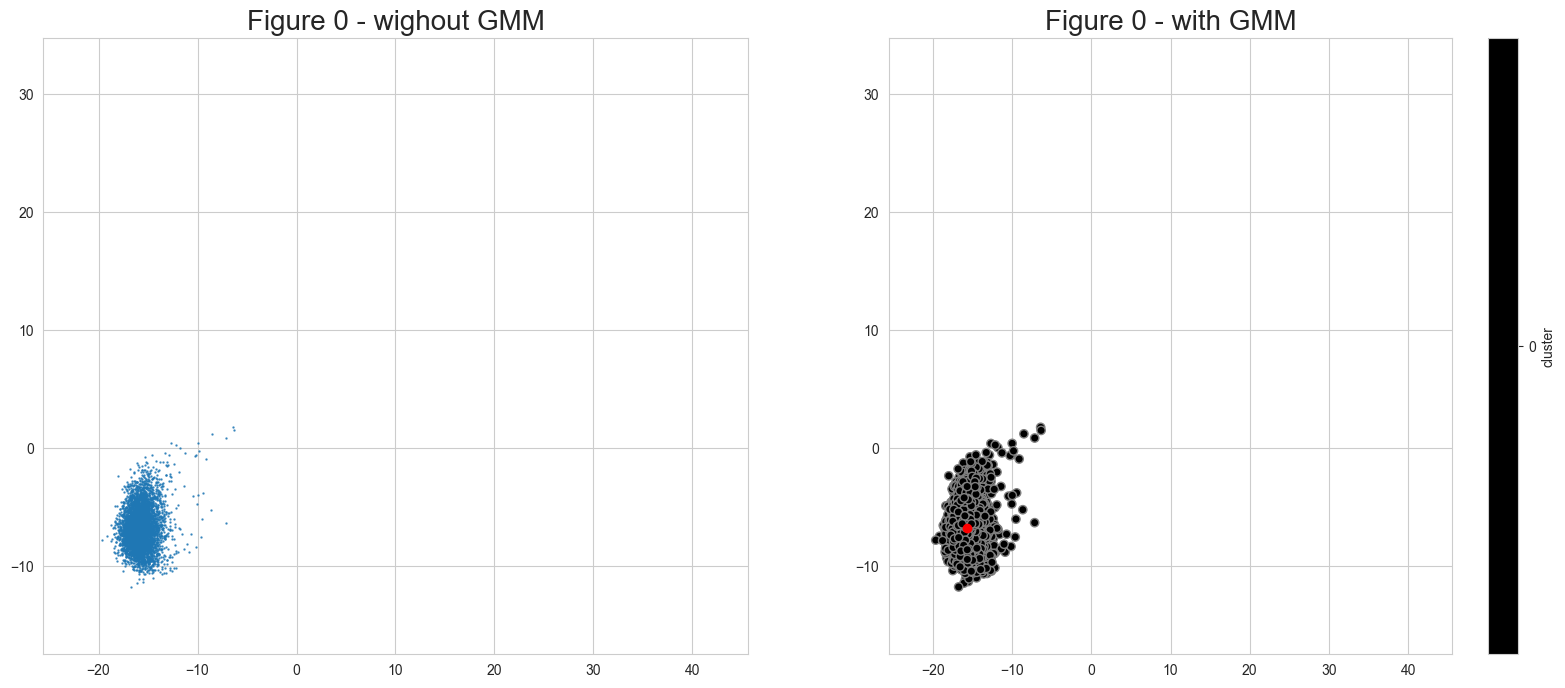

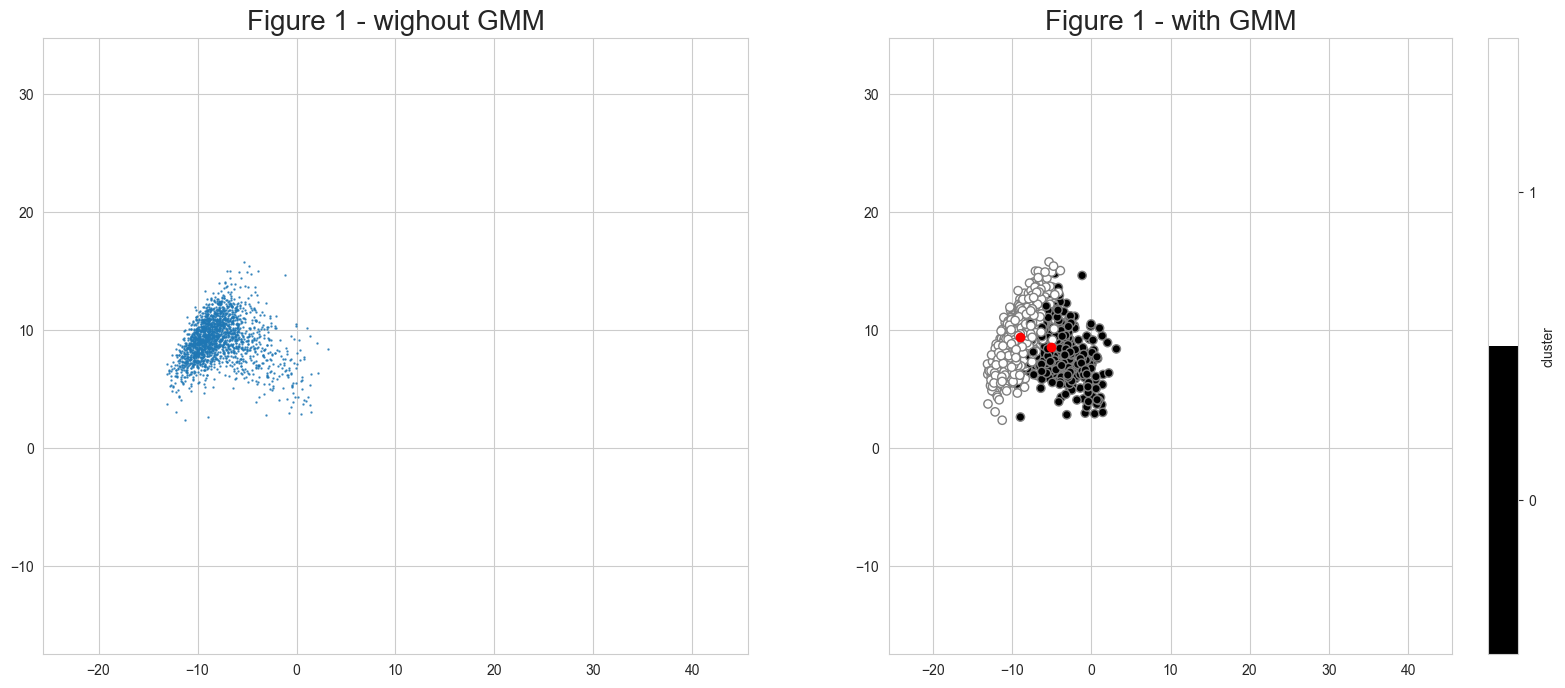

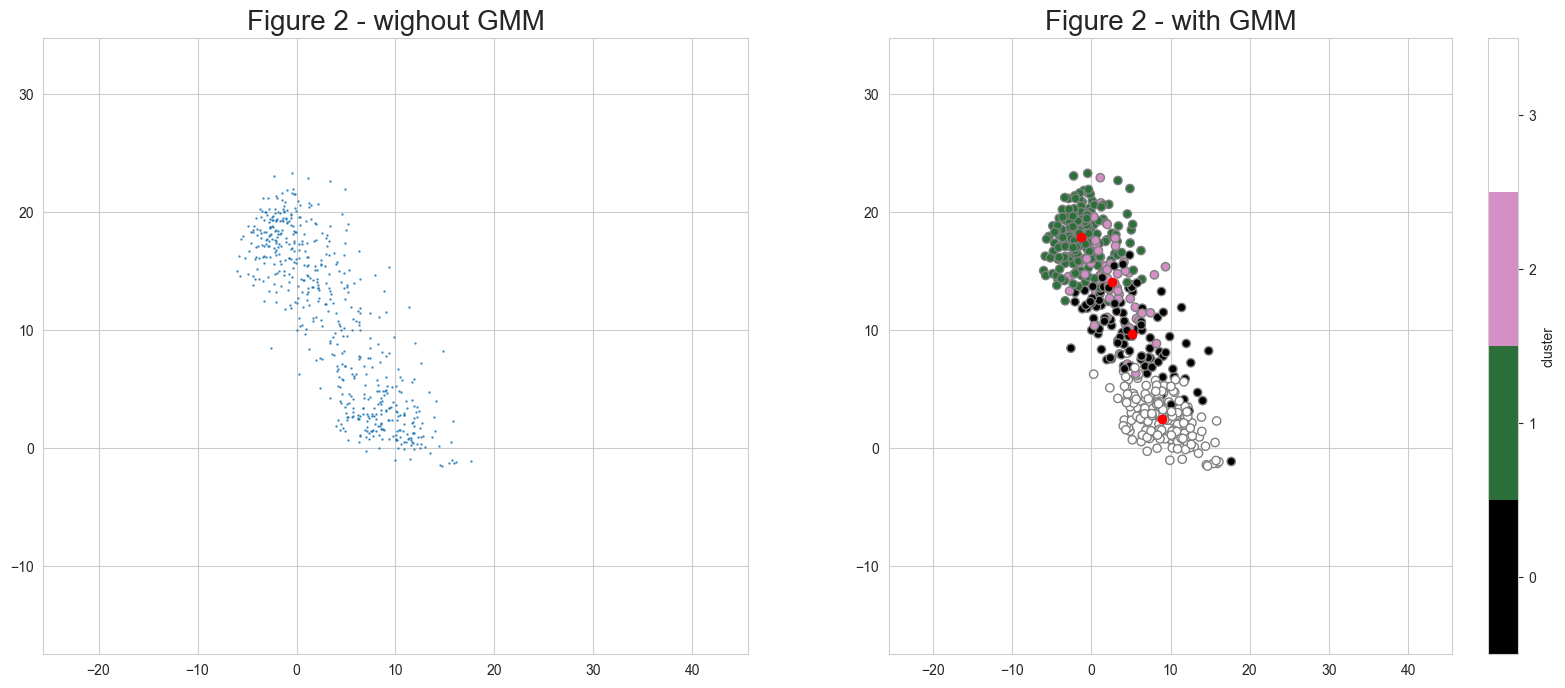

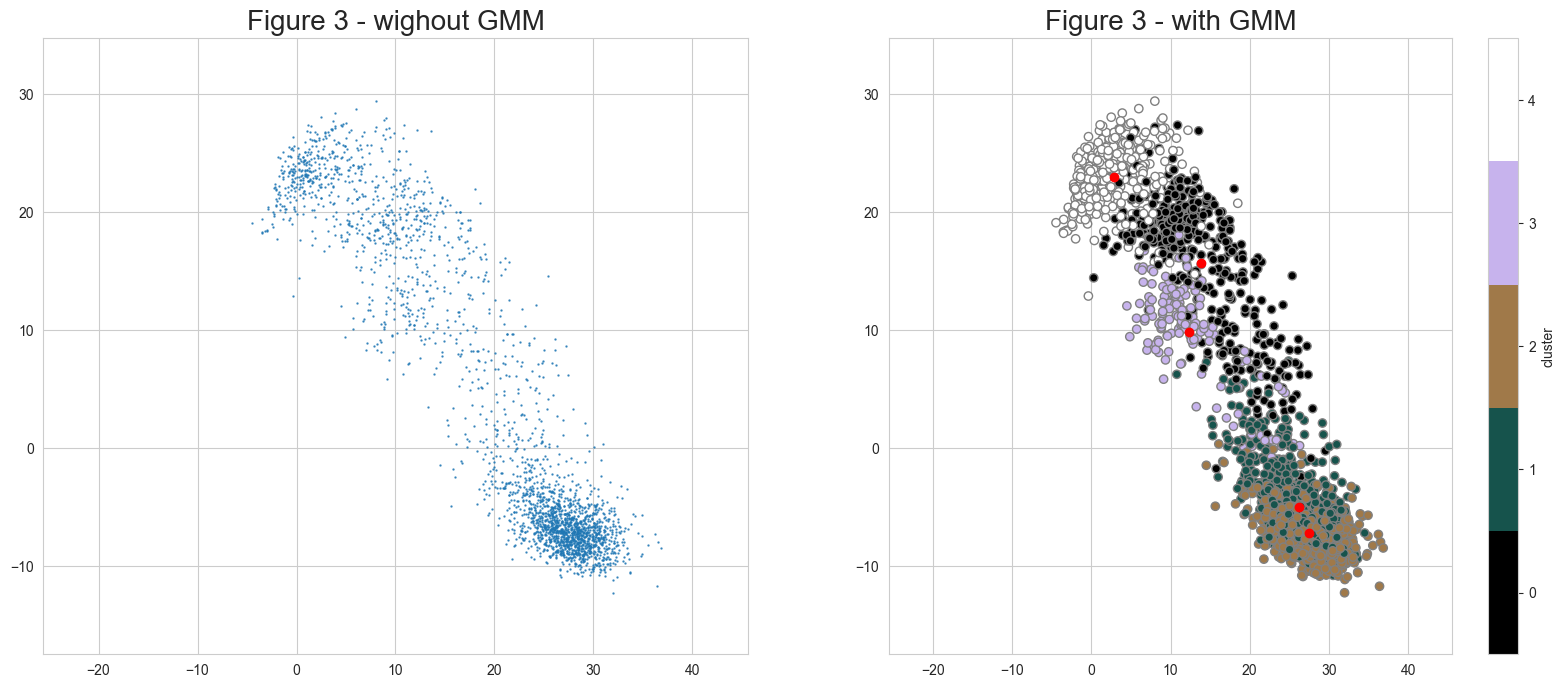

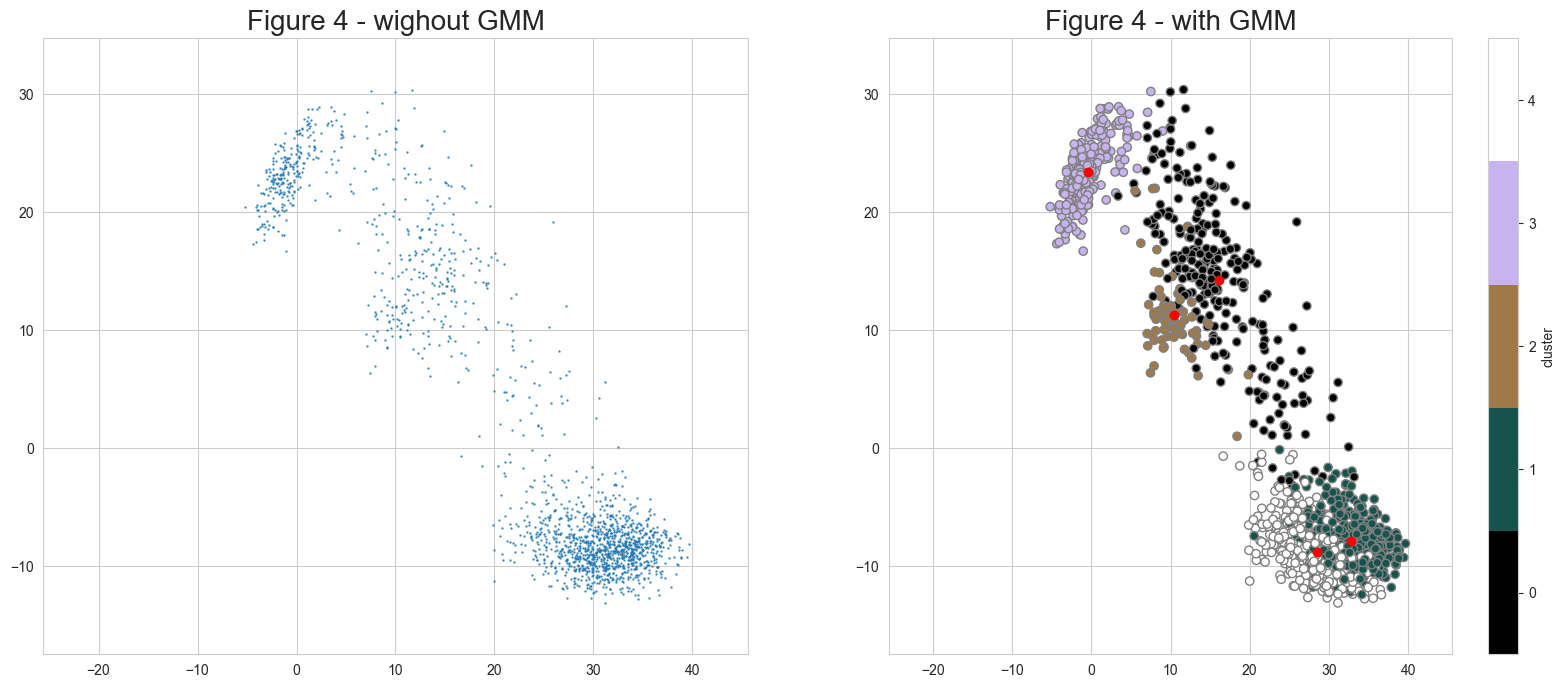

In [64]:
scegot.plot_gmm_predictions(X, gmm_models, gmm_labels, plot_gmm_means=True)

In [33]:
%%time
scegot.umap_n_components = UMAP_N_COMPONENTS
scegot.umap_n_neighbors = UMAP_N_NEIGHBORS
X_2, umap_model = scegot.apply_umap(X, random_state=RANDOM_STATE)

CPU times: user 1min 54s, sys: 1.62 s, total: 1min 56s
Wall time: 42.2 s


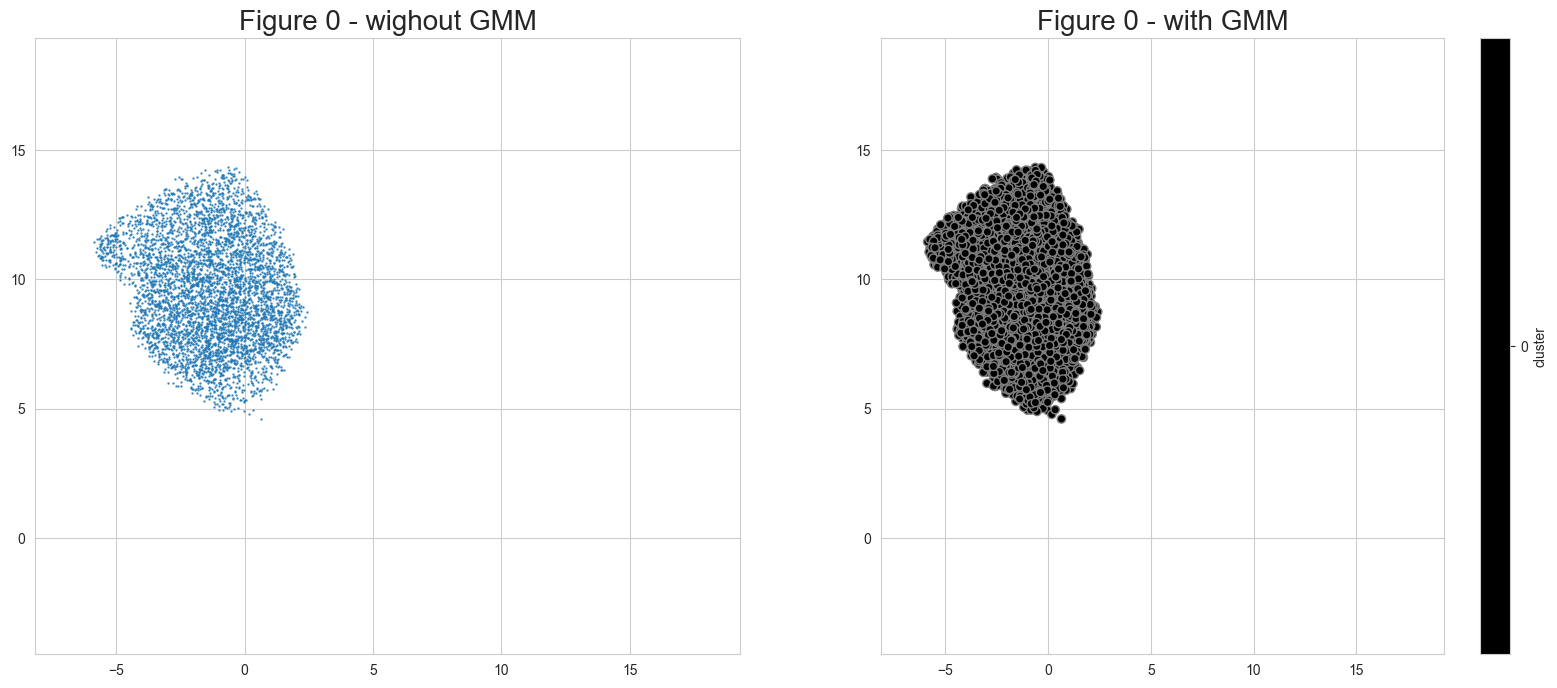

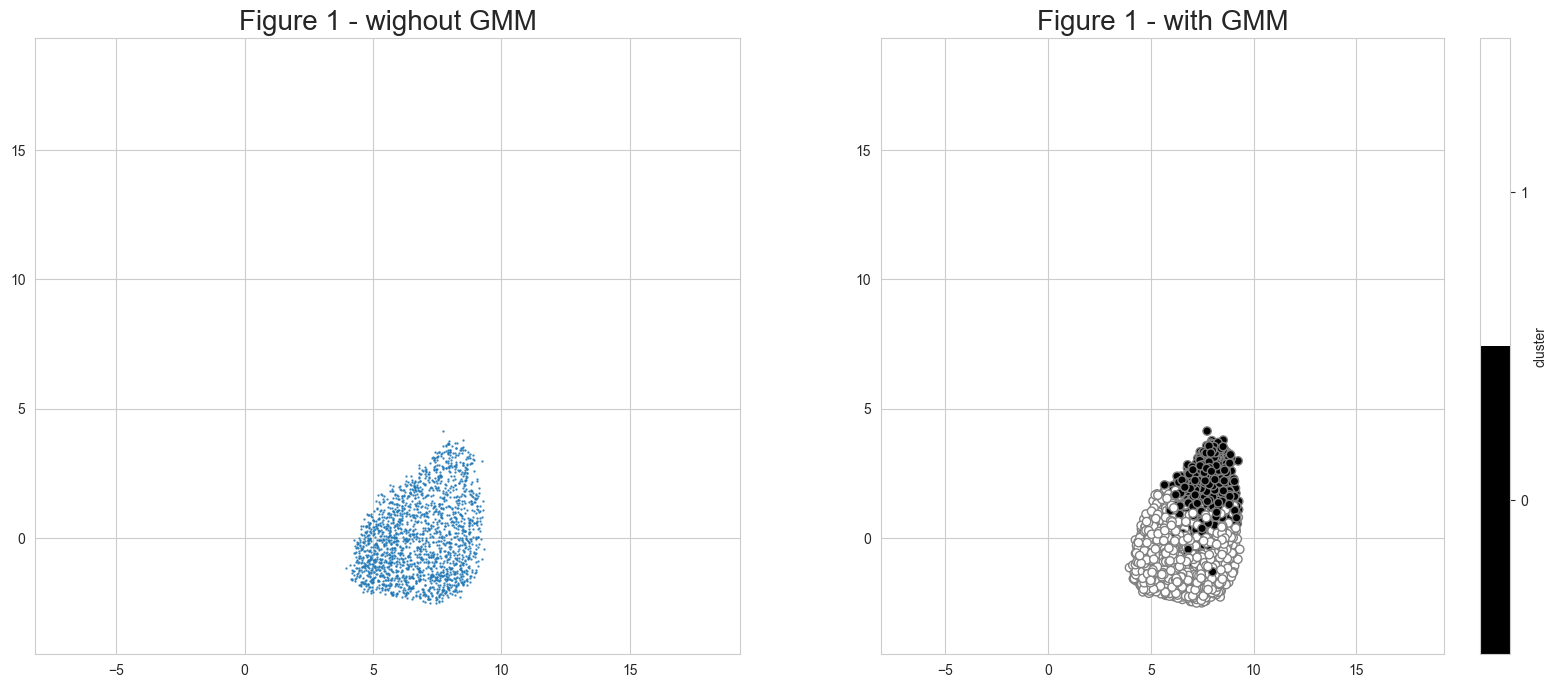

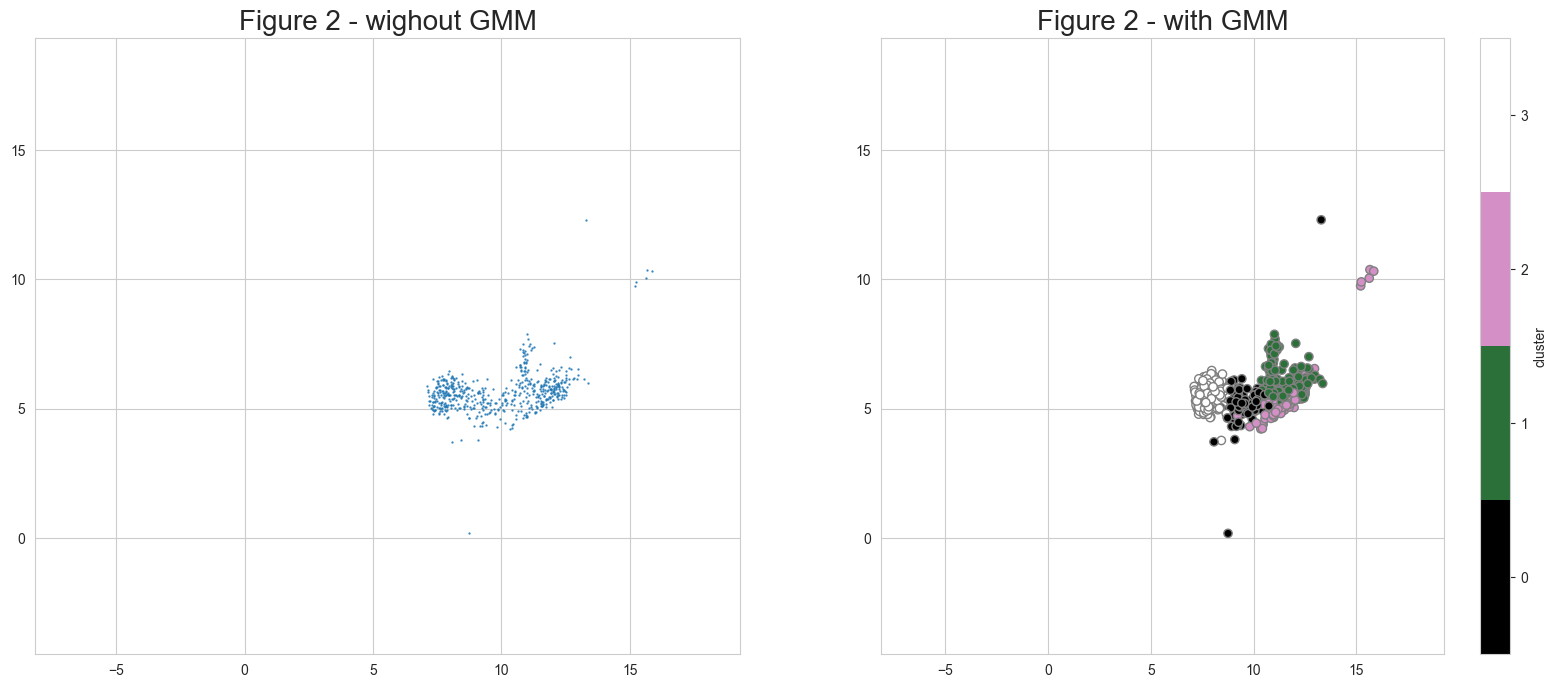

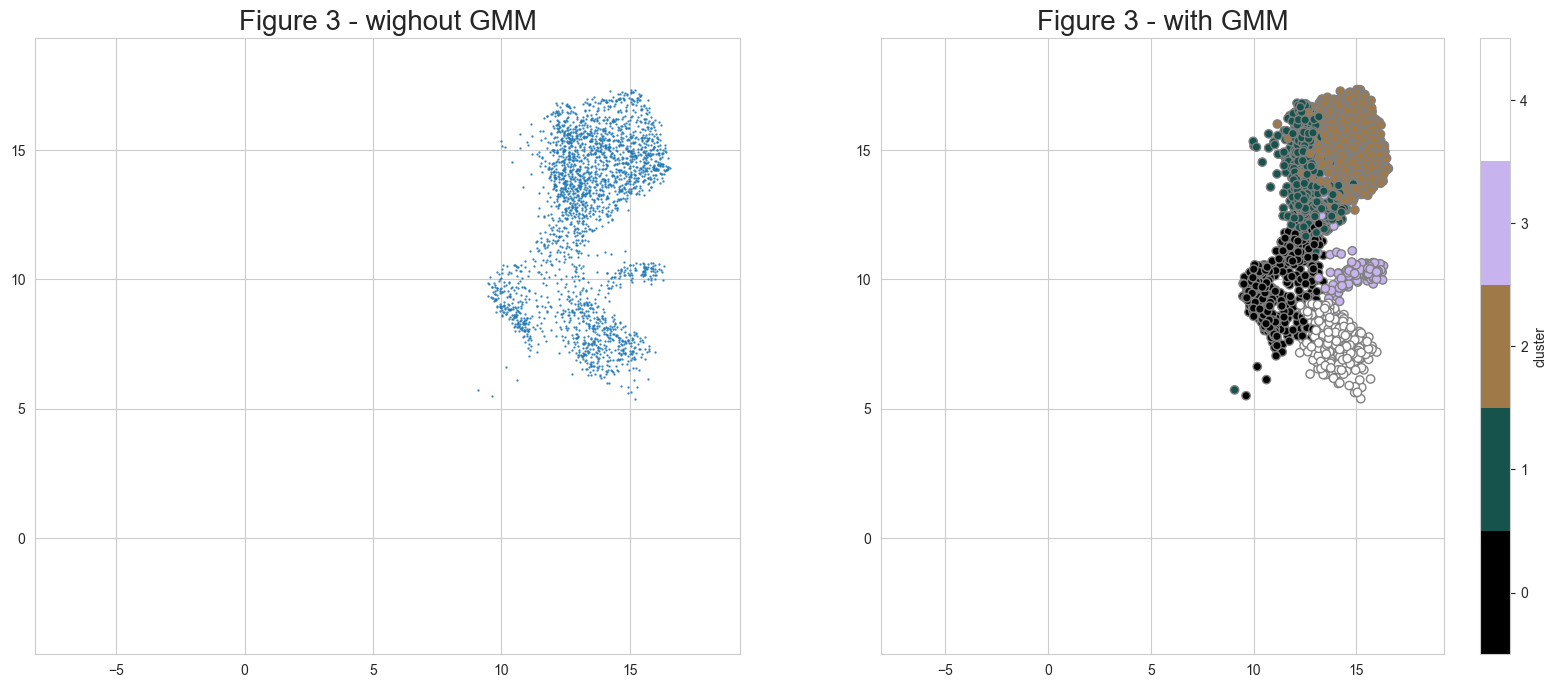

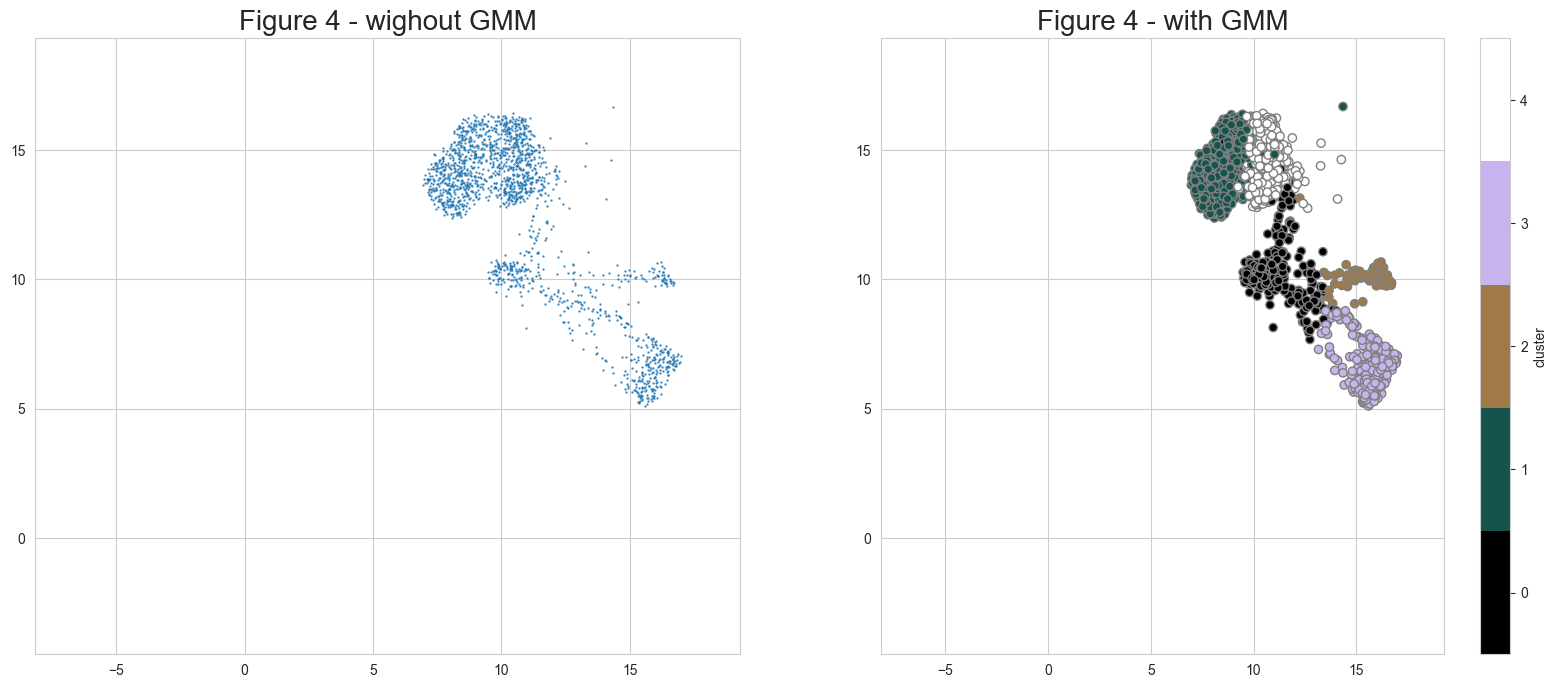

In [34]:
scegot.plot_gmm_predictions(X_2, gmm_models, gmm_labels)

In [35]:
DAY_NAMES = ["day 0", "day 0.5", "day 1", "day 1.5", "day 2"]

In [36]:
scegot.animate_cell_state(X, gmm_models, DAY_NAMES)

100%|███████████████████████████████████████████| 11/11 [00:10<00:00,  1.09it/s]


In [37]:
cluster_names = scegot.generate_cluster_names_with_day(DAY_NAMES)
cluster_names

[['day 0-cluster 0'],
 ['day 0.5-cluster 0', 'day 0.5-cluster 1'],
 ['day 1-cluster 0', 'day 1-cluster 1', 'day 1-cluster 2', 'day 1-cluster 3'],
 ['day 1.5-cluster 0',
  'day 1.5-cluster 1',
  'day 1.5-cluster 2',
  'day 1.5-cluster 3',
  'day 1.5-cluster 4'],
 ['day 2-cluster 0',
  'day 2-cluster 1',
  'day 2-cluster 2',
  'day 2-cluster 3',
  'day 2-cluster 4']]

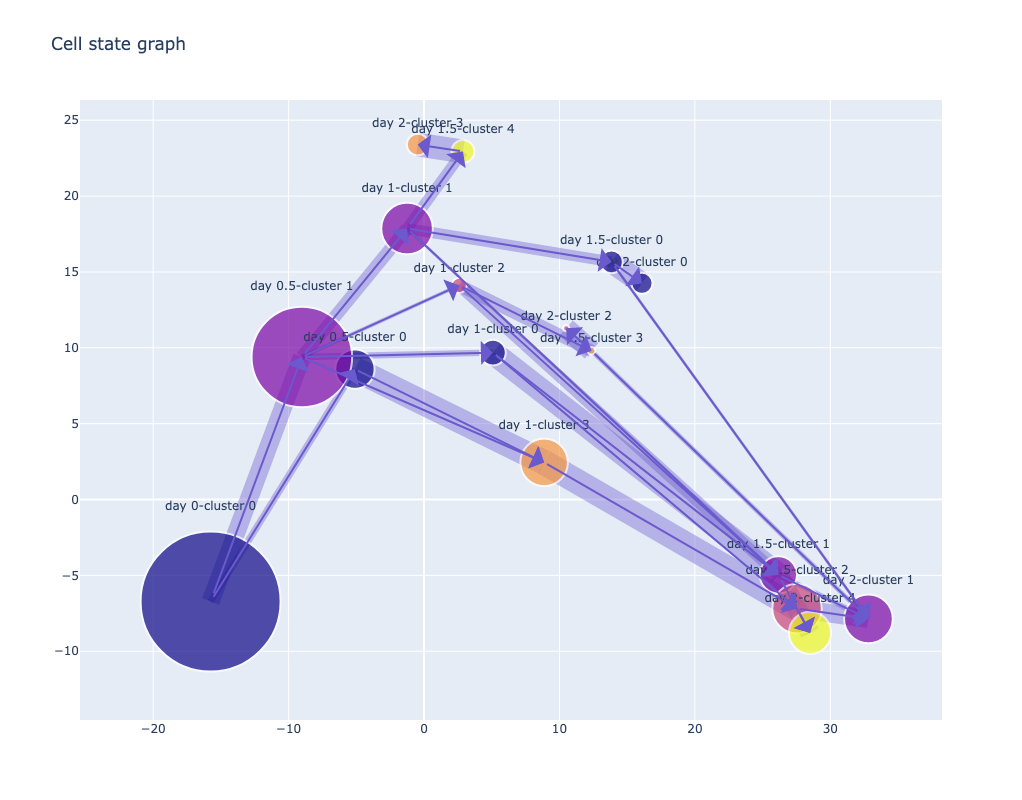

In [102]:
scegot.plot_cell_state_graph(
    gmm_models,
    X_raw[0].columns,
    pca_model,
    cluster_names,
    tf_gene_names,
    [0, 0.5, 1, 1.5, 2],
)

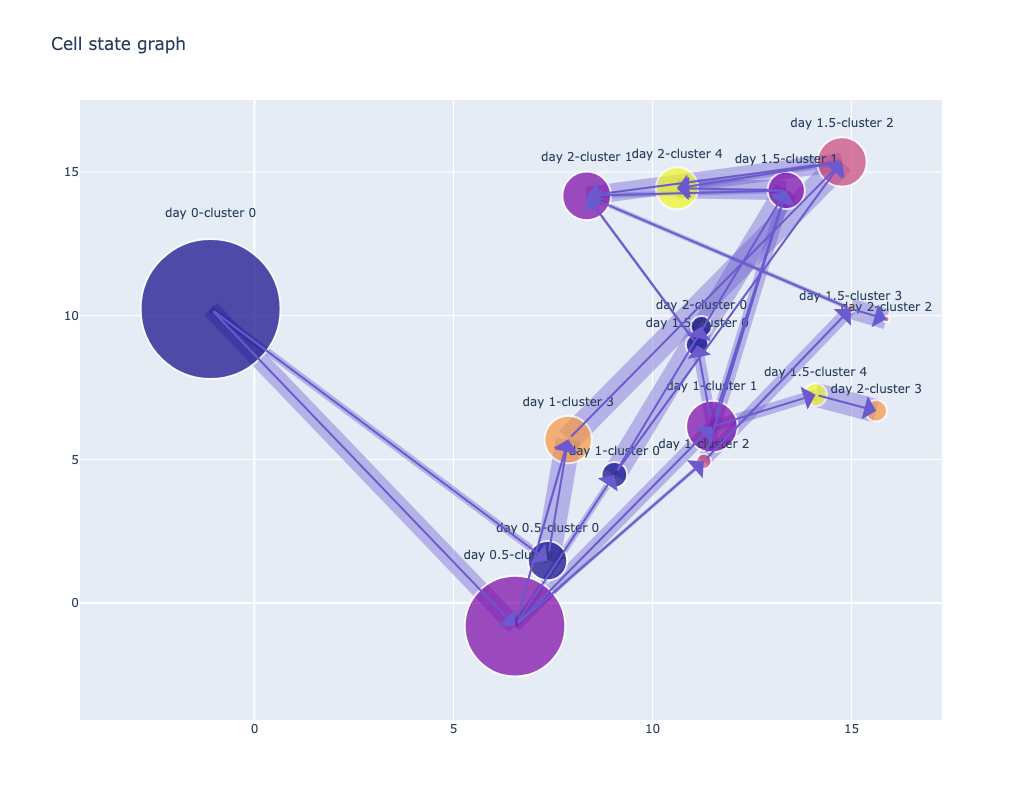

In [103]:
scegot.plot_cell_state_graph(
    gmm_models,
    X_raw[0].columns,
    pca_model,
    cluster_names,
    tf_gene_names,
    [0, 0.5, 1, 1.5, 2],
    umap_model,
)

In [40]:
df_genes_per_cluster = scegot.get_gmm_mean_gene_values_per_cluster(
    scegot.get_gmm_means(gmm_models),
    pca_model,
    cluster_name_list=list(itertools.chain.from_iterable(cluster_names)),
    gene_name_list=X_raw[0].columns,
)
# df_genes_per_cluster = df_genes_per_cluster.where(df_genes_per_cluster > 0, 0)

In [41]:
df_TFgenes = df_genes_per_cluster.loc[
    :, df_genes_per_cluster.columns.isin(tf_gene_names)
]

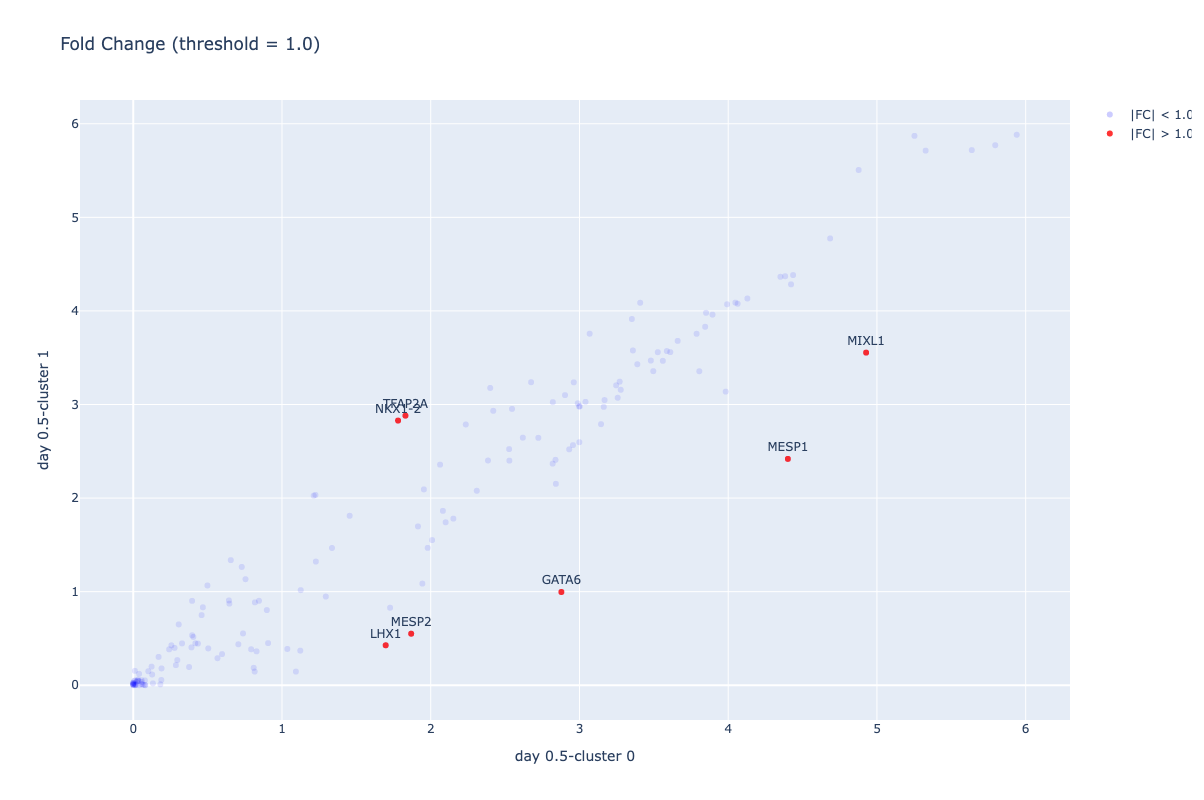

In [42]:
# Fold Change
scegot.plot_fold_change(
    df_TFgenes, "day 0.5-cluster 0", "day 0.5-cluster 1", threshold=1.0
)